In [1]:
using DynamicalSystems
using LinearAlgebra
# using ProgressBars
using Base.Iterators
using Plots
using DifferentialEquations
using ProgressMeter
using NPZ

In [2]:
σ(x) = 1/(1+exp(-x));
W(α,θ) = α*[cos(θ) -sin(θ); sin(θ) cos(θ)];
# RNN(u,α,θ) = tanh.(W(α,θ)*u).-u

In [3]:
function RNN(dx, x, p, n)
#     dx[1] = 1.0 - p[1]*x[1]^2 + x[2]
#     dx[2] = p[2]*x[1]
    α,θ = p
    dx.=tanh.(W(α,θ)*x)
    return
end
# Jacobian:
function RNN_jac(J, x, p, n)
    α,θ = p
    dx=tanh.(W(α,θ)*x)
    J.= Diagonal(1. .-dx.^2)*W(α,θ)
    return
end

RNN_jac (generic function with 1 method)

In [4]:
αs = collect(1.1:0.1:10.)
αs = prepend!(αs, 1. .+[1e-3,1e-2])
αs = prepend!(αs, collect(0:0.1:1.))
θs = range(0, stop=π/4, length=25)

stuff_to_loop_over = product(αs,θs)|>collect;
numel = length(stuff_to_loop_over);
Λ₁s = zeros(Float64, numel);
Λ₂s = zeros(Float64, numel);

In [5]:
p = Progress(numel);
jj = Threads.Atomic{Int}(0)
l = Threads.SpinLock()

Threads.@threads for i in 1:numel
    
    α, θ = stuff_to_loop_over[i]
    ds = DiscreteDynamicalSystem(RNN, rand(2), [α θ],RNN_jac)
    λs = lyapunovs(ds, 5e4; Ttr = Int(5e2))
    Λ₁s[i]= λs[1]
    Λ₂s[i]= λs[2]
    
    Threads.atomic_add!(jj, 1)
    Threads.lock(l)
        update!(p, jj[])
    Threads.unlock(l)
end
npzwrite("LE_rnn_tanh_new.npz", Dict("alphas" => αs, "thetas" => θs, "LE1" => Λ₁s, "LE2"=>Λ₂s))

Progress: 100%|█████████████████████████████████████████| Time: 0:18:06


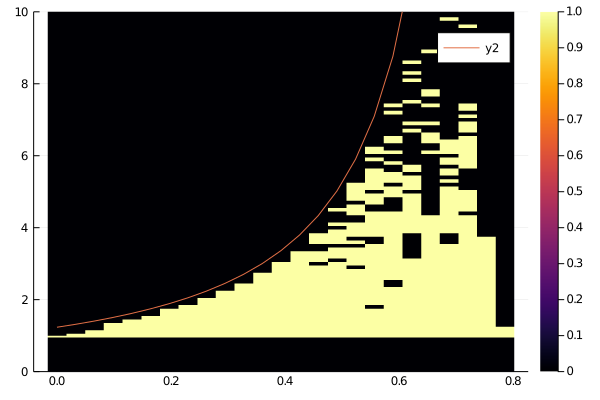

In [31]:
heatmap(θs, αs, reshape(Λ₁s,length(αs),length(θs)).>-0.001)
f(x) = 1/abs(x-pi/4)^(43/32)-0.15
plot!(θs, f.(θs))
ylims!(0.,10.)

#### pltΛ₁s = heatmap(θs, αs, Λ₁s, colorbar=false)
pltΛ₂s = heatmap(θs, αs, Λ₂s)

pl = plot(pltΛ₁s,pltΛ₂s, layout=(1,2), clims=(minimum(Λ₂s),maximum(Λ₁s)))
# savefig(pl,"vanillaRNNLE_10steps.pdf")

In [5]:
function GRU!(du,u,p,t)
    α,θ,β = p
    r = 0.5
    du .= (σ(β)-1).*(u - tanh.(0.5.*W(α,θ)*u)) + σ(β).*u
end

GRU! (generic function with 1 method)

In [6]:
αs = collect(2.1:0.1:10.)
αs = prepend!(αs, 2. .+[1e-3,1e-2])
αs = prepend!(αs, collect(0:0.1:2.))

θs = range(0, stop=π, length=100)
gates = -5.:1.:5.
stuff_to_loop_over = product(αs,θs,gates)|>collect;

numel = length(stuff_to_loop_over);
Λ₁s = zeros(Float64, numel);
Λ₂s = zeros(Float64, numel);

p = Progress(numel);
jj = Threads.Atomic{Int}(0)
l = Threads.SpinLock()

Threads.@threads for i in 1:numel
    
    α, θ, gate = stuff_to_loop_over[i]
    ds = DiscreteDynamicalSystem(GRU!, [0.5,0.5], [α θ gate])
    λs = lyapunovs(ds, 1e4; Ttr = Int(5e2))
    Λ₁s[i]= λs[1]
    Λ₂s[i]= λs[2]
    
    Threads.atomic_add!(jj, 1)
    Threads.lock(l)
        update!(p, jj[])
    Threads.unlock(l)
end
npzwrite("LE_rnn_gru.npz", Dict("alpha" => αs, "thetas" => θs, "gates"=>gates, "LE1" => Λ₁s, "LE2"=>Λ₂s))

Progress: 100%|█████████████████████████████████████████| Time: 4:56:11m:57


In [13]:
tmp = reshape(Λ₁s, (length(αs),length(θs),length(gates)))

103×100×11 Array{Float64,3}:
[:, :, 1] =
 -0.0134761  -0.0134761  -0.0134761  …  -0.0134761  -0.0134761  -0.0134761
 -0.0651265  -0.0650984  -0.0650141     -0.0132839  -0.0133416  -0.0133546
 -0.119591   -0.119528   -0.11934       -0.0134758  -0.013476   -0.013476
 -0.177193   -0.177087   -0.176771      -0.0134761  -0.0134761  -0.0134761
 -0.238317   -0.238158   -0.237682      -0.0134761  -0.0134761  -0.0134761
 -0.303422   -0.303196   -0.302518   …  -0.0134761  -0.0134761  -0.0134761
 -0.373063   -0.372751   -0.371816      -0.0134761  -0.0134761  -0.0134761
 -0.447918   -0.447496   -0.44623       -0.0134761  -0.0134761  -0.0134761
 -0.528834   -0.528266   -0.526567      -0.0134761  -0.0134761  -0.0134761
 -0.616879   -0.616117   -0.613839      -0.0134761  -0.0134761  -0.0134761
 -0.71343    -0.712403   -0.709337   …  -0.0134761  -0.0134761  -0.0134761
 -0.820309   -0.818912   -0.814743      -0.0134761  -0.0134761  -0.0134761
 -0.939994   -0.938058   -0.932296      -0.0134761  -0.01347

In [27]:
plotlyjs()

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-2452087470530063402\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-5796056909888921420\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-2452087470530063402\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Plots.PlotlyJSBackend()

In [41]:
heatmap(θs,αs,tmp[:,:,11])

<!DOCTYPE html>
 
 
 Plots.jl